# <font color="purple"> TDP43_WT_OE_PB_experiment_sorted - Testing pixel-level colocalization of V5 (TDP-43) in P-bodies (DCP1A) </font>
-----

## **The Goal:** test the hypothesis that *the colocalization of TDP-43 in DCP1A-positive pixels is significantly greater than expected under spatial randomization.*

-----
Action items: 

Analyzing TDP43_dNLS_Monocolonal panelA (DCP1A and V5 TDP-43 staining) in the same cells from preprocessed sites (not tiles!). Three batches, 4 reps each. ±200 sites per well. Formula should be P(TDP|P-bodies) (as we did to Coyne data, with binary masks, ignoring pixel intensities)

---

- Load rescaled SITES (filtered after Brenner). Note that “stress” is “DOX”
---
- Compute fraction_overlap for every site image - Compare markers tiles of DCP1A and V5 (panelA):

- **"Fraction Overlap"** is the pixel-level measure of intereset, using binary masks (ignoring intensities, and looking only on overlap). “Out of all pixels that are ‘on’ in the DCP1A channel (i.e., part of a P-body), what fraction are also ‘on’ in the TDP-43 channel?” That’s a **colocalization as conditional probability P(TDP+|DCP1A+)** — measuring whether TDP-43 signal appears in P-body regions, pixel-by-pixel. 
- - This gives you "true overlap". 
---
- Rotation test (AKA, channel rotation as a null model) to demonstrate that observed pixel-level overlap (e.g., P(TDP+ | DCP1A+)) is **real and significantly higher than expected by chance** 

- - This gives you "rotated overlap": fraction_overlap_rotated (via 90° TDP rotation)

---

- Plot real vs rotated distributions. We should see a clear shift of the real distribution to the right.

---

- Statistical test (paired!): wilcoxon

---

- Reproducibility: plot means per batch and replicate

---







## <font color="darkpink"> Imports</font>


In [1]:
import os
import sys
import numpy as np
import pandas as pd
%matplotlib inline

from scipy.stats import wilcoxon

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

os.environ['NOVA_HOME'] = '/home/projects/hornsteinlab/Collaboration/NOVA'
sys.path.insert(1, os.getenv('NOVA_HOME'))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from manuscript.plot_config import PlotConfig
from tools.preprocessing_tools.image_sampling_utils import sample_images_all_markers_all_lines
from tools.channels_colocalization.pixel_colocalization_utils import sites_paths_to_dataframe, match_sites_and_score_fraction_overlap

%load_ext autoreload
%autoreload 2

NOVA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA
NOVA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA


## <font color="darkpink"> Globals and Functions</font>

In [2]:
# dNLS V5 dataset
MAIN_DATA_PATH = os.path.join(os.environ['NOVA_HOME'], 'cell_profiler', 'outputs', 'filtered_by_brenner_post_rescale_outputs', 'TDP43_WT_OE_PB_experiment_sorted')
BATCHES = ['batch1', 'batch2', 'batch3'] 

# Save figures here
save_path = '/home/projects/hornsteinlab/Collaboration/NOVA/outputs/vit_models/finetunedModel_MLPHead_acrossBatches_B56789_80pct_frozen/figures/dNLS_V5/channels_colocalization/'

# Font
FONT_PATH = '/home/projects/hornsteinlab/sagyk/anaconda3/envs/nova/fonts/arial.ttf'
from matplotlib import font_manager as fm
import matplotlib
fm.fontManager.addfont(FONT_PATH)
matplotlib.rcParams['font.family'] = 'Arial'

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8
})


In [3]:
color_mapping = PlotConfig().COLOR_MAPPINGS_DOX


def load_sites_paths_V5(input_dir, batches):
    
    all_paths = []
    for batch in batches:
        
        # --- Sample preprocesed sites (preprocesed=rescale intensities and filter by Brenner)
        paths = sample_images_all_markers_all_lines(input_dir_batch=os.path.join(input_dir, batch),
                                                    _sample_size_per_markers=300, 
                                                    _num_markers=4, 
                                                    raw=True, 
                                                    all_conds=True, 
                                                    rep_count=4, 
                                                    cond_count=2, 
                                                    exclude_DAPI=True, 
                                                    markers_to_include=['DCP1A', 'V5'])
        
        # only TDP43_dNLS_Monocolonal cell line is in our interest in this analysis
        filtered_paths = [p for p in paths if 'TDP43_dNLS_Monocolonal/PanelA/stress/' in p]
        print(f"TDP43_dNLS_Monocolonal - Batch: {batch}. Loaded {len(filtered_paths)} site images.")
        
        all_paths += filtered_paths

        
    print(f"Total of {len(all_paths)} site images are sampled (each is a tiff file).")
    return all_paths

# <font color="darkpink"> Step1: Load paths and metadata of site images</font>
here, the numpy (images) are not saved in the dataframe, only path to tiff file. 
Loading of images is done in lazy manner 

In [4]:
paths = load_sites_paths_V5(MAIN_DATA_PATH, BATCHES)
df = sites_paths_to_dataframe(paths)

TDP43_dNLS_Monocolonal - Batch: batch1. Loaded 1242 site images.
TDP43_dNLS_Monocolonal - Batch: batch2. Loaded 1292 site images.
TDP43_dNLS_Monocolonal - Batch: batch3. Loaded 1249 site images.
Total of 3783 site images are sampled (each is a tiff file).
Created DataFrame of 3783 sites with their paths and metadata (to suuport lazy loading).


# <font color="darkviolet"> Step 2: Compute fraction_overlap per tile (lazy load of images)</font>

In [5]:
df_DCP1A = match_sites_and_score_fraction_overlap(df, 
                                                  tdp43_threshold_method="mean+2sd",
                                                  dcp1a_threshold_method="mean+2.5sd",
                                                 ) 

df_DCP1A.shape: (1909, 8), and df_TDP43.shape (1874, 8)
Matching multiplexed sites and scoreing sites for "fraction_overlap" and "fraction_overlap_rotated".
Sites without matched TDP43: 102


## <font color="darkviolet"> Plot real "fraction_overlap" vs "fraction_overlap_rotated" distributions </font>


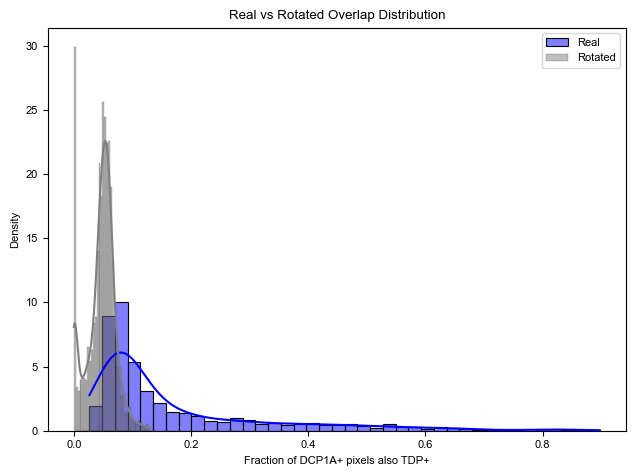

In [6]:


sns.histplot(df_DCP1A['fraction_overlap'], label='Real', color='blue', kde=True, stat="density", bins=40)
sns.histplot(df_DCP1A['fraction_overlap_rotated'], label='Rotated', color='gray', kde=True, stat="density", bins=40)
plt.xlabel("Fraction of DCP1A+ pixels also TDP+")
plt.ylabel("Density")
plt.title("Real vs Rotated Overlap Distribution")
plt.legend()
plt.tight_layout()
plt.show()



## <font color="darkviolet"> Summary statistics - Aggregate by cell line and rep </font>

In [7]:
df_DCP1A.groupby(['batch', 'rep'])['fraction_overlap'].agg(['mean', 'std', 'count']).reset_index()

,batch,rep,mean,std,count
0,batch1,rep1,0.291622,0.260085,101
1,batch1,rep2,0.221167,0.191640,149
2,batch1,rep3,0.142076,0.119950,167
3,batch1,rep4,0.150472,0.131264,170
4,batch2,rep1,0.165464,0.169448,143
5,batch2,rep2,0.160495,0.139725,169
6,batch2,rep3,0.132847,0.115874,163
7,batch2,rep4,0.139925,0.118454,149
8,batch3,rep1,0.251593,0.201551,115
9,batch3,rep2,0.190562,0.146342,139


In [8]:
df_DCP1A.groupby(['batch', 'rep'])['fraction_overlap_rotated'].agg(['mean', 'std', 'count']).reset_index()

,batch,rep,mean,std,count
0,batch1,rep1,0.038261,0.029910,101
1,batch1,rep2,0.043251,0.025696,149
2,batch1,rep3,0.048208,0.020539,167
3,batch1,rep4,0.047781,0.020886,170
4,batch2,rep1,0.046390,0.024676,143
5,batch2,rep2,0.048753,0.021613,169
6,batch2,rep3,0.053940,0.020205,163
7,batch2,rep4,0.046305,0.020291,149
8,batch3,rep1,0.033593,0.030477,115
9,batch3,rep2,0.043314,0.027280,139


# <font color="darkgreen"> Step 3: Paired statistical testing - Wilcoxon</font>

### <font color="deeppink"> Use a rotation test to demonstrate that observed pixel-level overlap (e.g., P(TDP+ | DCP1A+)) is real and significantly higher than expected by chance</font>

### <font color="deeppink"> Tests the null hypothesis: "Overlap is no greater than what we'd expect by chance (rotation)".. </font>
    
### <font color="deeppink">Alternative='greater': test whether real overlap is significantly greater than rotated (null).</font>






In [9]:
# Drop rows with missing values in required columns
df_clean = df_DCP1A[['fraction_overlap', 'fraction_overlap_rotated', 'cell_line', 'batch', 'rep']].dropna()
print(f"Removing rows with missing values: remaining with {df_clean.shape[0]} out of {df_DCP1A.shape[0]}")

summary = (
    df_clean.groupby(['batch', 'rep'])['fraction_overlap']
    .mean()
    .reset_index()
    .sort_values(['batch', 'rep'])
)

stat, p = wilcoxon(df_clean['fraction_overlap'], 
                   df_clean['fraction_overlap_rotated'], 
                   alternative='greater')

# Compute means
real_mean = np.mean(df_clean['fraction_overlap'])
rotated_mean = np.mean(df_clean['fraction_overlap_rotated'])

# Compute effect size (difference in means)
mean_diff = real_mean - rotated_mean

# Print summary
print("=== Overlap vs Rotated Colocalization Test ===")
print(f"Number of images: {len(df_clean)}")
print(f"Mean real overlap:     {real_mean:.3f}")
print(f"Mean rotated overlap:  {rotated_mean:.3f}")
print(f"Mean difference:       {mean_diff:.3f}")
print(f"Wilcoxon signed-rank test statistic: {stat:.3f}")
print(f"p-value (H1: real > rotated):        {p:.4g}")

# Interpretation
if p < 0.05:
    print("\n✅ Interpretation: The real colocalization is significantly higher than expected by chance.")
    print("   This suggests that TDP-43 is truly enriched in DCP1A-positive pixels.")
else:
    print("\n⚠️ Interpretation: The difference between real and rotated overlap is not statistically significant.")
    print("   This suggests the observed colocalization could be due to random spatial alignment.")



Removing rows with missing values: remaining with 1807 out of 1909
=== Overlap vs Rotated Colocalization Test ===
Number of images: 1807
Mean real overlap:     0.170
Mean rotated overlap:  0.047
Mean difference:       0.123
Wilcoxon signed-rank test statistic: 1588861.000
p-value (H1: real > rotated):        1.012e-265

✅ Interpretation: The real colocalization is significantly higher than expected by chance.
   This suggests that TDP-43 is truly enriched in DCP1A-positive pixels.


In [10]:


# NANCY TODO: Repeat the rotation multiple times per image for a stronger null distribution? account for batch/rep?







# <font color="plum"> Step 4: Visualization - Per-batch values - scater rep-level means </font>



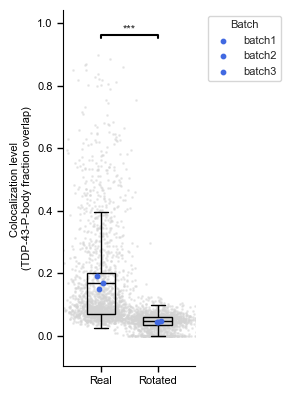

In [ ]:

# ========================
# 2. Prep data
# ========================
df_long = df_clean.melt(
    id_vars='batch',
    value_vars=['fraction_overlap', 'fraction_overlap_rotated'],
    var_name='metric',
    value_name='value'
)

df_long['metric'] = df_long['metric'].replace({
    'fraction_overlap': 'Real',
    'fraction_overlap_rotated': 'Rotated'
})
# ========================
# 3. Boxplot + scattter of raw values
# ========================
fig, ax = plt.subplots(figsize=(3, 4))
line_width = 1
sns.set_style("white")

x_pos_map = {'Real': 0, 'Rotated': 0.3}

for metric, xpos in x_pos_map.items():
    data_subset = df_long[df_long['metric'] == metric]

    # Boxplot at numeric position
    sns.boxplot(
        data=data_subset,
        y='value',
        ax=ax,
        width=0.15,
        linewidth=line_width,
        showmeans=True,
        showfliers=False,
        meanline=True,
        meanprops={"linestyle": "-", "color": "black", "linewidth": line_width},
        boxprops=dict(facecolor='none', edgecolor='black', linewidth=line_width),
        whiskerprops=dict(linewidth=line_width, color='black'),
        capprops=dict(linewidth=line_width, color='black'),
        medianprops=dict(visible=False),
        positions=[xpos]
    )
    
    # Adjust jitter width here
    jitter_width = 0.08  # try 0.05–0.1 for good visual spacing
    x_jittered = np.random.normal(loc=xpos, scale=jitter_width, size=len(data_subset))

    # Full distribution: manual scatter of raw cell-level/image-level points
    ax.scatter(
        x=x_jittered,
        y=data_subset['value'],
        color="lightgray",
        s=1,
        alpha=0.4,
        zorder=1
    )

    

# ========================
# 4. Batch mean dots
# ========================
batch_means = df_long.groupby(['batch', 'metric'])['value'].mean().reset_index()

color_map = {
    'batch1': 'royalblue',  
    'batch2': 'royalblue',  
    'batch3': 'royalblue',  
}


for _, row in batch_means.iterrows():
    
    x_pos = x_pos_map[row['metric']]
    # Jitter x slightly (mean = x, small std deviation)
    jittered_x = np.random.normal(loc=x_pos, scale=0.04)  # adjust scale if needed
    
    ax.scatter(
        x=jittered_x,
        y=row['value'],
        color=color_map.get(row['batch'], 'black'),
        edgecolor=None,
        s=10,
        label=row['batch'],
        zorder=3
    )

# Deduplicate legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Batch", bbox_to_anchor=(1.05, 1), loc='upper left')

# ========================
# 5. Wilcoxon + Annotation
# ========================
stat, p = wilcoxon(
    df_clean['fraction_overlap'], 
    df_clean['fraction_overlap_rotated'], 
    alternative='greater'
)

# Format p display
if p < 0.0001:
    p_text = "****"
elif p < 0.001:
    p_text = "***"
elif p < 0.01:
    p_text = "**"
elif p < 0.05:
    p_text = "*"
else:
    p_text = f"n.s. (p = {p:.2f})"


# Use actual data max to place the bridge line and text
ymin, ymax = ax.get_ylim()
y_range = ymax - ymin
buffer = 0.01 * ymax
line_y = ymax + buffer
text_y = line_y + 0.01 * ymax

# Bridge line
x1, x2 = 0, x_pos
ax.plot([x1, x1, x2, x2],
        [line_y, line_y + 0.01*ymax, line_y + 0.01*ymax, line_y],
        lw=1.5, c='black')

# Annotation text
ax.text((x1 + x2) / 2, text_y, p_text, ha='center', va='bottom', fontsize=8)



# Ensure tick marks are shown on both axes
ax.tick_params(
    axis='both',
    which='both',
    direction='out',   # or 'in' or 'inout'
    length=4,          # length of the tick marks
    width=1,           # thickness of the ticks
    bottom=True, top=False,    # x-axis ticks
    left=True, right=False     # y-axis ticks
)

# ========================
# 6. Final formatting
# ========================
ax.set_xticks(list(x_pos_map.values()))
ax.set_xticklabels(list(x_pos_map.keys()), rotation=0)

# Use actual plot limits to place annotation
ax.set_ylim(ymin - 0.05 * y_range, ymax + 0.1 * y_range)

min_x = min(x_pos_map.values())
max_x = max(x_pos_map.values())
buffer = 0.2
ax.set_xlim(min_x - buffer, max_x + buffer)

plt.ylabel("Colocalization level \n(TDP-43-P-body fraction overlap)")
plt.xlabel("")
sns.despine()
plt.tight_layout()


plt.savefig(save_path+"coloc_TDP43_P-bodies_V5.eps", dpi=300, bbox_inches='tight')
plt.savefig(save_path+"coloc_TDP43_P-bodies_V5.png", dpi=300, bbox_inches='tight')
plt.show()

## <font color="darkviolet"> coefficient of variation (CV)  per batch </font>

### Reproducibility and stability of overlap measurements across batches

#### General interpretation of CV:
#### - CV < 0.1: Excellent reproducibility

#### - CV 0.1 – 0.2: Acceptable

#### - CV > 0.2: High variability — investigate further

    batch      mean       std        CV
0  batch1  0.201334  0.069866  0.347013
1  batch2  0.149683  0.015755  0.105253
2  batch3  0.178149  0.056078  0.314782

Mean -> Central tendency (average overlap score)
SD -> Absolute spread — how much replicates vary in raw units (e.g. 0.04)
CV = SD/Mean -> Relative variability within batch. This is normalized measure of consistency (unitless measure that helps you determine if your overlap measurement is stable across replicates in each batch)


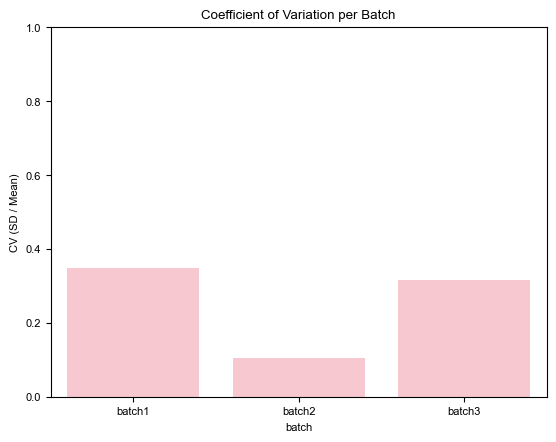

In [11]:
summary = (
    df_clean.groupby(['batch', 'rep'])['fraction_overlap']
    .mean()
    .reset_index()
    .sort_values(['batch', 'rep'])
)

repro_stats = (
    summary.groupby('batch')['fraction_overlap']
    .agg(['mean', 'std'])
    .assign(CV=lambda d: d['std'] / d['mean'])
    .reset_index()
)
print(repro_stats)
print("\nMean -> Central tendency (average overlap score)")
print("SD -> Absolute spread — how much replicates vary in raw units (e.g. 0.04)")
print("CV = SD/Mean -> Relative variability within batch. This is normalized measure of consistency (unitless measure that helps you determine if your overlap measurement is stable across replicates in each batch)")

sns.barplot(data=repro_stats, x='batch', y='CV', color="pink")
plt.title("Coefficient of Variation per Batch")
plt.ylabel("CV (SD / Mean)")
plt.ylim(0, 1)
plt.show()


# <font color="goldenrod"> Reproducibility: plot means per batch and replicate </font>


/tmp/ipykernel_2941137/2956091501.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(


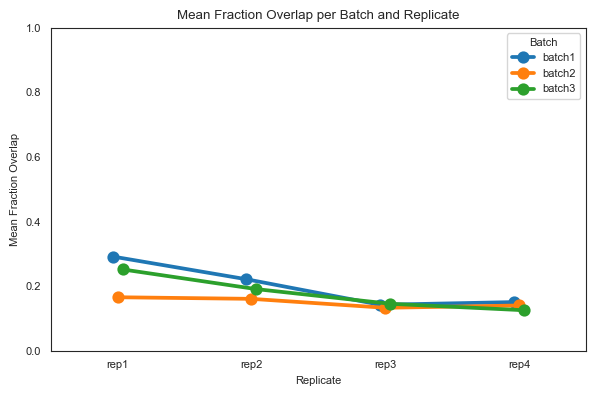

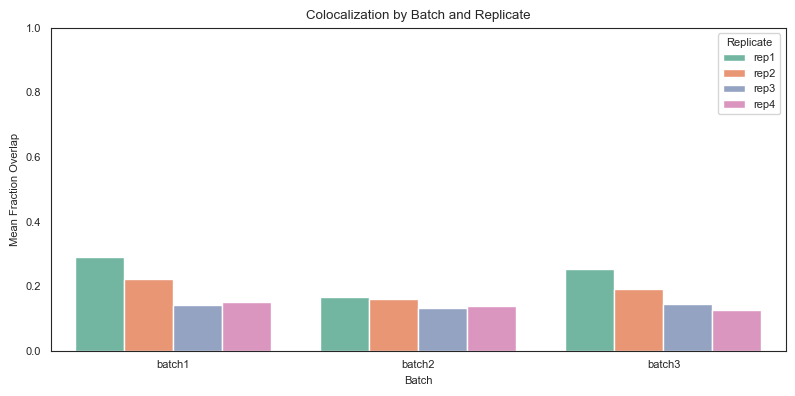

In [14]:


plt.figure(figsize=(6, 4))

# Option A: Line plot (connect replicates per batch)
sns.pointplot(
    data=summary,
    x='rep',
    y='fraction_overlap',
    hue='batch',
    markers='o',
    dodge=True,
    ci=None
)

plt.title("Mean Fraction Overlap per Batch and Replicate")
plt.ylabel("Mean Fraction Overlap")
plt.xlabel("Replicate")
plt.ylim(0, 1)
plt.legend(title="Batch")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))

sns.barplot(
    data=summary,
    x='batch',
    y='fraction_overlap',
    hue='rep',
    palette='Set2'
)

plt.title("Colocalization by Batch and Replicate")
plt.ylabel("Mean Fraction Overlap")
plt.xlabel("Batch")
plt.ylim(0, 1)
plt.legend(title="Replicate")
plt.tight_layout()
plt.show()



/tmp/ipykernel_2941137/3833144753.py:24: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.pointplot(


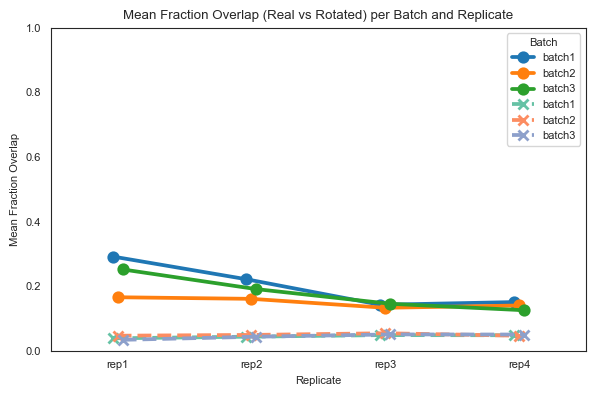

In [15]:
# Compute per-replicate means for both real and rotated
summary = (
    df_clean.groupby(['batch', 'rep'])
    [['fraction_overlap', 'fraction_overlap_rotated']]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6, 4))

# Real overlap
sns.pointplot(
    data=summary,
    x='rep',
    y='fraction_overlap',
    hue='batch',
    markers='o',
    dodge=True,
    errorbar=None,
    linestyles='-',
)

# Rotated overlap
sns.pointplot(
    data=summary,
    x='rep',
    y='fraction_overlap_rotated',
    hue='batch',
    markers='x',
    dodge=True,
    errorbar=None,
    linestyles='--',
    palette=sns.color_palette("Set2"),  # match colors
    legend=True  # prevent duplicate legends
)

plt.title("Mean Fraction Overlap (Real vs Rotated) per Batch and Replicate")
plt.ylabel("Mean Fraction Overlap")
plt.xlabel("Replicate")
plt.ylim(0, 1)
plt.legend(title="Batch")
plt.tight_layout()
plt.show()


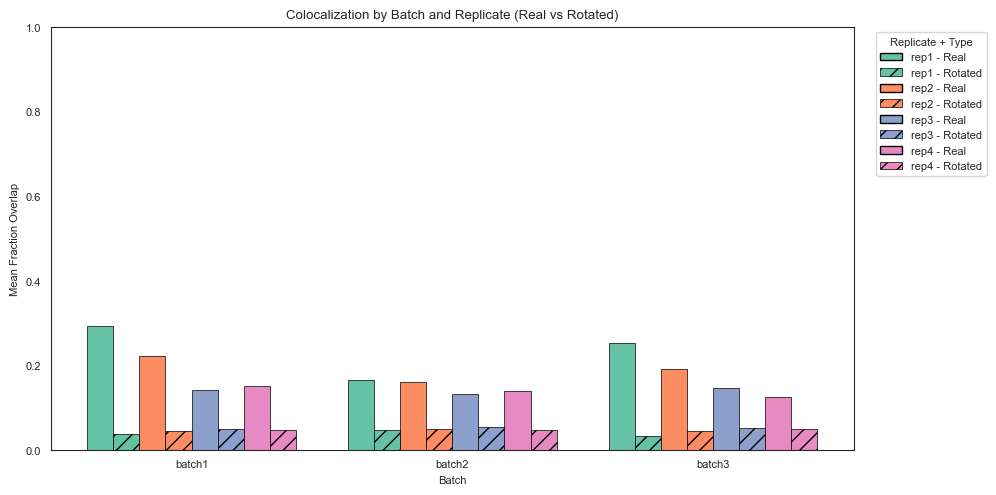

In [16]:

# -------------------------------
# Step 1: Create `long_df` from summary
# -------------------------------

# Example: Ensure your summary contains these columns:
# 'batch', 'rep', 'fraction_overlap', 'fraction_overlap_rotated'

# Melt wide-form summary into long-form dataframe
long_df = pd.melt(
    summary,
    id_vars=['batch', 'rep'],
    value_vars=['fraction_overlap', 'fraction_overlap_rotated'],
    var_name='type',
    value_name='overlap'
)

# Map type to clean labels
long_df['type'] = long_df['type'].map({
    'fraction_overlap': 'Real',
    'fraction_overlap_rotated': 'Rotated'
})

# Create a composite key for grouping in plot
long_df['rep_type'] = long_df['rep'].astype(str) + '-' + long_df['type']

# -------------------------------
# Step 2: Plot grouped bars with hatch for rotated
# -------------------------------

# Consistent base color per replicate
rep_order = sorted(long_df['rep'].unique())
base_palette = dict(zip(rep_order, sns.color_palette("Set2", n_colors=len(rep_order))))

# Start the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Plot bars manually
batches = sorted(long_df['batch'].unique())
rep_type_order = sorted(long_df['rep_type'].unique())
bar_width = 0.8 / len(rep_type_order)

for i, batch in enumerate(batches):
    for j, rep_type in enumerate(rep_type_order):
        row = long_df[(long_df['batch'] == batch) & (long_df['rep_type'] == rep_type)]
        if row.empty:
            continue

        y = row['overlap'].values[0]
        rep = row['rep'].values[0]
        is_rotated = 'Rotated' in rep_type
        xpos = i - 0.4 + j * bar_width + bar_width / 2

        ax.bar(
            xpos,
            y,
            width=bar_width,
            color=base_palette[rep],
            edgecolor='black',
            hatch='//' if is_rotated else '',
            linewidth=0.5,
            label=rep_type if i == 0 else None
        )

# Set axes and labels
ax.set_xticks(range(len(batches)))
ax.set_xticklabels(batches)
ax.set_xlabel("Batch")
ax.set_ylabel("Mean Fraction Overlap")
ax.set_ylim(0, 1)
ax.set_title("Colocalization by Batch and Replicate (Real vs Rotated)")

# -------------------------------
# Step 3: Custom legend with hatch
# -------------------------------

legend_patches = []
for rep in rep_order:
    patch_real = mpatches.Patch(facecolor=base_palette[rep], edgecolor='black', label=f"{rep} - Real")
    patch_rot = mpatches.Patch(
        facecolor=base_palette[rep],
        edgecolor='black',
        hatch='//',
        label=f"{rep} - Rotated",
        linewidth=0.5
    )
    legend_patches.extend([patch_real, patch_rot])

ax.legend(handles=legend_patches, title="Replicate + Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


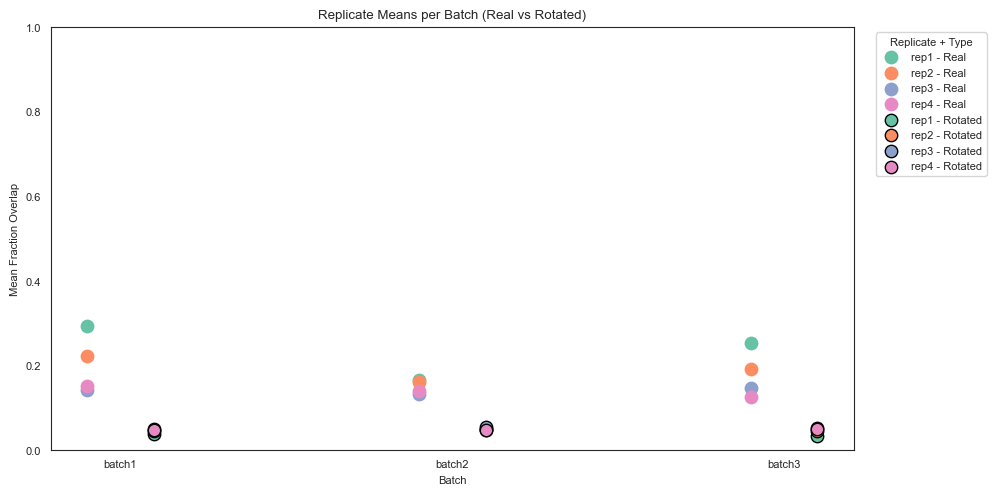

In [17]:

# ------------------------------------
# Step 1: Prepare long_df
# ------------------------------------

# Melt wide-form summary into long-form dataframe
long_df = pd.melt(
    summary,
    id_vars=['batch', 'rep'],
    value_vars=['fraction_overlap', 'fraction_overlap_rotated'],
    var_name='type',
    value_name='overlap'
)

# Map type to clean labels
long_df['type'] = long_df['type'].map({
    'fraction_overlap': 'Real',
    'fraction_overlap_rotated': 'Rotated'
})

# Create plotting order
batches = sorted(long_df['batch'].unique())
rep_order = sorted(long_df['rep'].unique())

# Define consistent color palette per replicate
base_palette = dict(zip(rep_order, sns.color_palette("Set2", n_colors=len(rep_order))))

# ------------------------------------
# Step 2: Plot scatter points
# ------------------------------------

plt.figure(figsize=(10, 5))
ax = plt.gca()

# Define horizontal spacing
x_positions = {batch: i for i, batch in enumerate(batches)}
type_offset = {'Real': -0.1, 'Rotated': 0.1}  # offset for side-by-side scatter

for _, row in long_df.iterrows():
    batch = row['batch']
    rep = row['rep']
    overlap = row['overlap']
    col_type = row['type']

    x = x_positions[batch] + type_offset[col_type]

    # Marker style for rotated
    marker = 'o' if col_type == 'Real' else 'o'
    facecolor = base_palette[rep]
    edgecolor = 'black' if col_type == 'Rotated' else None

    ax.scatter(
        x,
        overlap,
        color=facecolor,
        edgecolor=edgecolor,
        s=80,
        marker=marker,
        linewidth=1,
        label=f"{rep} - {col_type}" if batch == batches[0] else None  # label once per rep_type
    )

# ------------------------------------
# Step 3: Format axes and legend
# ------------------------------------

ax.set_xticks(range(len(batches)))
ax.set_xticklabels(batches)
ax.set_xlabel("Batch")
ax.set_ylabel("Mean Fraction Overlap")
ax.set_ylim(0, 1)
ax.set_title("Replicate Means per Batch (Real vs Rotated)")

# Build custom legend (only unique labels)
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Replicate + Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [18]:
print("Done!")

Done!
